In [138]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import pandas as pd
import json
import geopandas as gpd
from shapely.wkt import loads

# loading the main dataframe
main_df = pd.read_csv("20181024_d1_0830_0900_segmented_oneaxistrajectory_traffic.csv")
# loading the traffic light states
with open("20181024_d1_0830_0900_traffic_light_states.json") as f:
    traffic_info = json.load(f)
# loading the segments
segments_gdf = gpd.read_file("20181024_d1_0830_0900_segments.csv")
segments_gdf["geometry"] = segments_gdf["geometry"].apply(loads)
# loading the traffic lights
traffic_lights_df = pd.read_csv("traffic_lights.csv")


In [8]:
main_df

,lat,lon,speed,lon_acc,lat_acc,time,dist_to_start,dist_to_end,veh_id,segment_id,temp_distance,one_axis_trajectory,closest_traffic_light,distance_to_traffic_light
0,37.979949,23.735613,29.3152,-0.1790,-0.0253,0.00,9.254831,459.678657,32.0,1.0,3.190766,2.642236e+06,0,43.220861
1,37.979946,23.735615,29.2910,-0.1578,-0.0291,0.04,9.586996,459.303356,32.0,1.0,3.224027,2.642237e+06,0,43.597100
2,37.979944,23.735617,29.2684,-0.1552,-0.0329,0.08,9.857971,459.030760,32.0,1.0,3.188256,2.642237e+06,0,43.873348
3,37.979941,23.735619,29.2469,-0.1446,-0.0366,0.12,10.194706,458.655467,32.0,1.0,3.221517,2.642237e+06,0,44.249611
4,37.979939,23.735621,29.2288,-0.1061,-0.0403,0.16,10.467632,458.382890,32.0,1.0,3.185746,2.642237e+06,0,44.525965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672406,37.980044,23.735572,28.9885,0.3464,0.7262,818.64,6.830528,470.813214,918.0,0.0,0.196335,2.642232e+06,0,32.183260
672407,37.980041,23.735574,29.0103,0.3757,0.7476,818.68,6.678863,470.437966,918.0,0.0,0.229596,2.642232e+06,0,32.559763
672408,37.980039,23.735576,29.0349,0.3894,0.7668,818.72,6.627068,470.165489,918.0,0.0,0.193825,2.642232e+06,0,32.838304
672409,37.980036,23.735577,29.0621,0.4186,0.7833,818.76,6.446423,469.823714,918.0,0.0,0.314004,2.642232e+06,0,33.173530


In [47]:
from pyproj import Transformer

def lat_lon_to_axis(lat, lon, axis_direction=(1, 0), crs="EPSG:3857"):
    global i
    """
    Convert latitude and longitude to a one-dimensional value in meters along an axis.

    Args:
        lat (float): Latitude of the point.
        lon (float): Longitude of the point.
        axis_direction (tuple): Direction vector of the axis (x, y).
        crs (str): CRS for projecting to meters (default: EPSG:3857).

    Returns:
        float: One-dimensional projection value in meters.
    """
    
    # Define the transformer for projecting lat/lon to the desired CRS
    transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
    
    # Project the latitude and longitude to meters
    x, y = transformer.transform(lon, lat)
    
    # Normalize the axis direction vector
    axis_vector = np.array(axis_direction)
    axis_unit_vector = axis_vector / np.linalg.norm(axis_vector)
    
    # Compute the projection of the point onto the axis
    projection_value = np.dot([x, y], axis_unit_vector)

    return projection_value



In [48]:
traffic_lights_df["one_axis_trajectory"] = traffic_lights_df.apply(lambda row: lat_lon_to_axis(row["lat"], row["lon"]), axis=1)

In [ ]:
copy_main_df = main_df.copy()
copy_main_df["traffic_light_one_axis"] = copy_main_df.apply(lambda row: traffic_lights_df[traffic_lights_df.index == row["closest_traffic_light"]].one_axis_trajectory.values[0], axis=1)

<Axes: xlabel='time'>

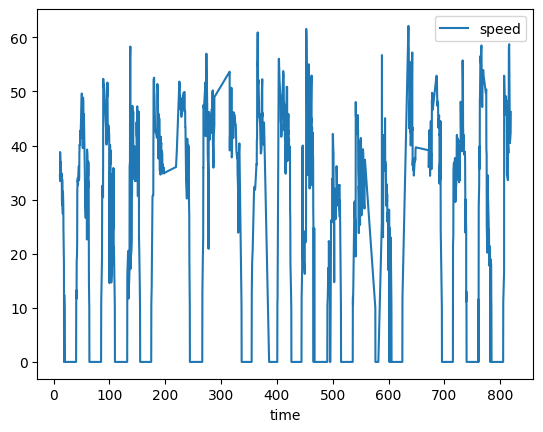

In [105]:
truncated_df = copy_main_df[copy_main_df["one_axis_trajectory"] < copy_main_df["traffic_light_one_axis"]]
truncated_df = truncated_df[truncated_df["distance_to_traffic_light"]< 25]

grouped_df = truncated_df.groupby(["closest_traffic_light", "time"]).mean().reset_index()[["time", "speed", "closest_traffic_light"]].sort_values(by="time")
grouped_df.loc[grouped_df["speed"] < 10, "speed"] = 0
grouped_df[grouped_df["closest_traffic_light"] == 2].plot(x="time", y="speed")

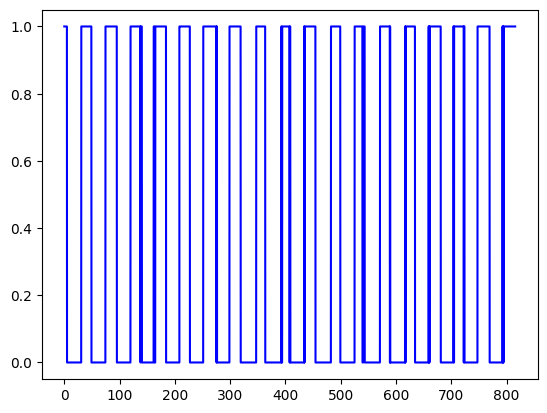

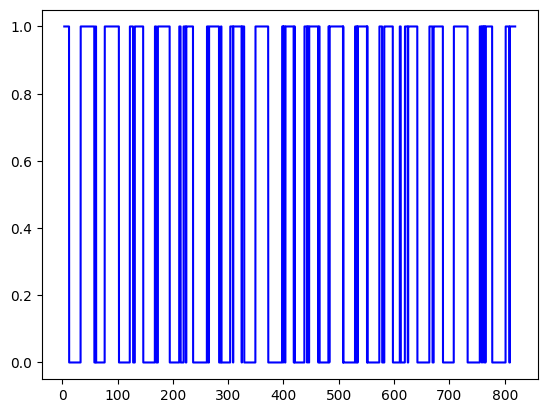

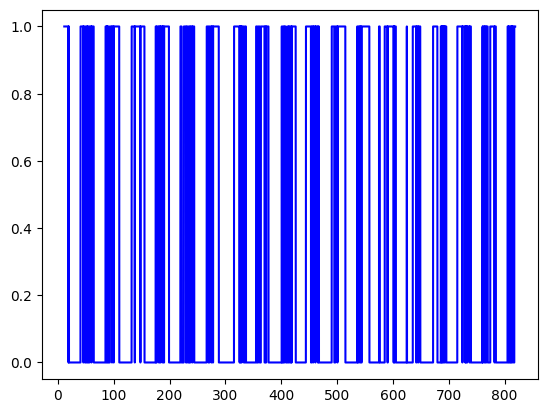

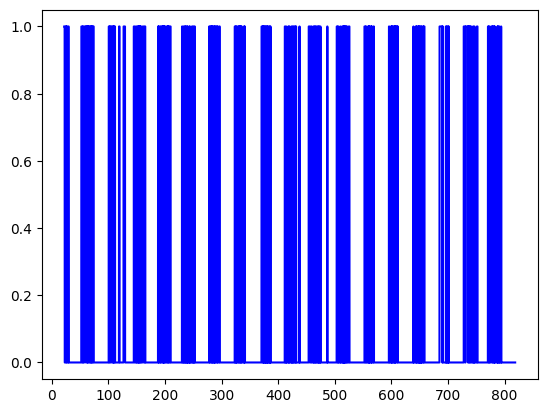

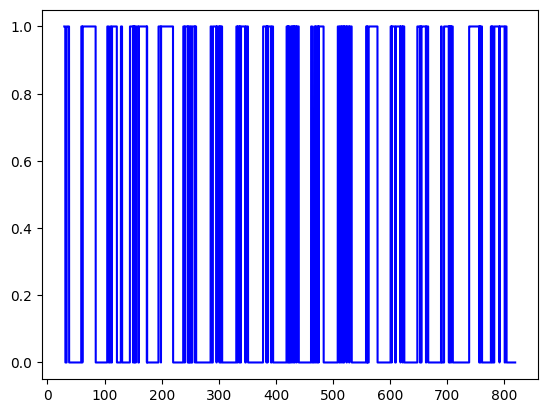

In [143]:
import numpy as np
import pandas as pd

traffic_info_dict = {}
for closest_traffic_light in grouped_df["closest_traffic_light"].unique():
    traffic_light_df = grouped_df[grouped_df["closest_traffic_light"] == closest_traffic_light].copy()
    traffic_light_df["time_diff"] = traffic_light_df["time"].diff()
    # print(closest_traffic_light)
    # display(traffic_light_df[traffic_light_df["time_diff"] > 0.1])
    if traffic_light_df["time_diff"].max() > 0.1:
        # traffic_light_df = traffic_light_df.reset_index(drop=True)  # Reset index to avoid KeyError
        
        for idx, row in traffic_light_df[traffic_light_df["time_diff"] > 0.1].iterrows():
            # Ensure idx - 1 exists
            if idx > 0:
                end_time = row["time"]
                start_time = end_time - row["time_diff"]
                # if closest_traffic_light == 4:
                #     print(start_time, end_time)
                # Generate new rows
                new_times = np.arange(start_time + 0.04, end_time, 0.04)
                new_rows = pd.DataFrame({
                    "time": new_times,
                    "speed": 0,
                    "closest_traffic_light": closest_traffic_light,
                    "time_diff": 0.04
                })
                
                # Concatenate new rows
                traffic_light_df = pd.concat([traffic_light_df, new_rows], ignore_index=True)
    traffic_light_df = traffic_light_df.sort_values(by="time")
    traffic_light_df["traffic_status"] = np.where(traffic_light_df["speed"] < 10, "red", "green")
    traffic_info_dict[closest_traffic_light] = traffic_light_df[["time", "traffic_status"]]
    plt.plot(traffic_light_df["time"], np.where(traffic_light_df["speed"] < 10, 0, 1), color="blue")
    plt.show()

In [145]:
import pickle
# Save the dictionary
with open("traffic_info_dict.pkl", "wb") as f:
    pickle.dump(traffic_info_dict, f)